# HW3 Q1 Eigenface for face recognition

## (a) Download The Face Dataset and unzip faces.zip

## (b) Load the training set into a matrix X
load train data into train_data and train labels into train_labels.

load test data into test_data and test labels into test_labels

Train data shape: (540, 2500)


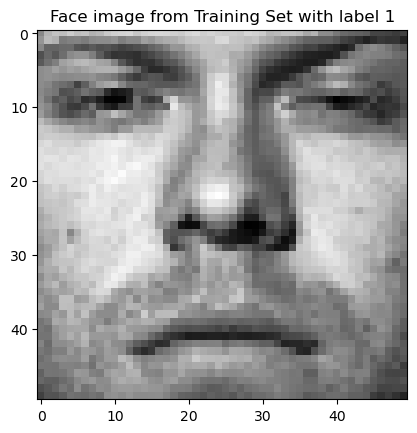

In [378]:
# import packages
import numpy as np
#from scipy import misc
import imageio.v2 as imageio
from matplotlib import pylab as plt
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# Load training set into a matrix X
train_labels, train_data = [], []
for line in open('./faces/train.txt'):
    im = imageio.imread(line.strip().split()[0])
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

# inspect data size to double check the load is correct
print("Train data shape:", train_data.shape)

# train set: pick a face image from X and display the image in grayscale.
plt.imshow(train_data[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title(f"Face image from Training Set with label {train_labels[10]}")
plt.savefig("Q1_b_face_train_set") # save pics
plt.show()

Test data shape: (100, 2500)


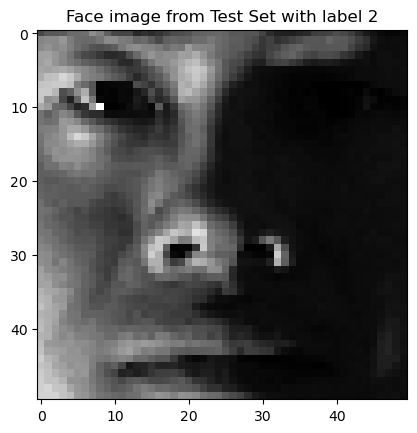

In [379]:
# Load test set into a matrix X_test
test_labels, test_data = [], []
for line in open('./faces/test.txt'):
    im = imageio.imread(line.strip().split()[0])
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

# inspect data size to double check the load is correct
print("Test data shape:", test_data.shape)

# test set - pick a face image from X_test and display that image in grayscale
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.title(f"Face image from Test Set with label {test_labels[10]}")
plt.savefig("Q1_b_face_test_set")
plt.show()

## (c) Average Face
Compute the average face µ from the whole training set by summing up every row in X then dividing by the number of faces. Display the average face as a grayscale image.

Average face shape: (2500,)


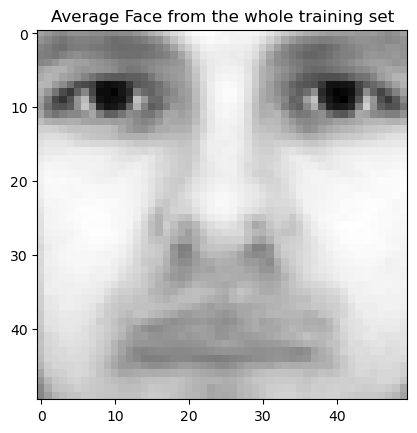

In [381]:
# summing up every row in X then dividing by the number of faces
average_face = np.mean(train_data, axis=0)
# print the size of average face，should be (2500,)
print("Average face shape:", average_face.shape)

# display the average face as a grayscale image
plt.imshow(average_face.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Average Face from the whole training set")
plt.savefig("Q1_c_avg_face_train_set")
plt.show()

## (d) Mean Subtraction

new X shape after mean subtraction:  (540, 2500)
new X_test shape after mean subtraction:  (100, 2500)


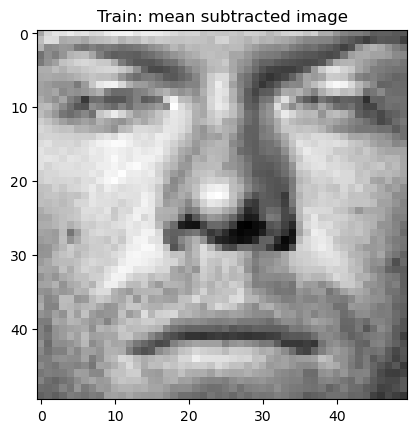

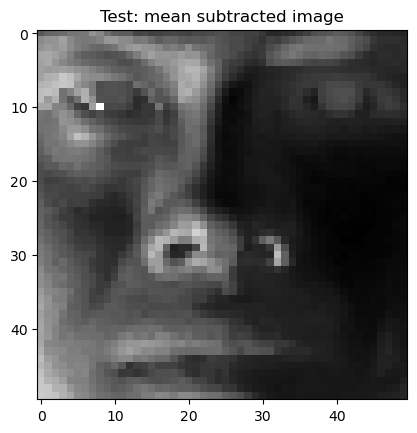

In [402]:
# subtract average face µ from every row in trainig and test set.
train_mean_sub = train_data - average_face
test_mean_sub = test_data - average_face
# print shape
print("new X shape after mean subtraction: ", train_mean_sub.shape)
print("new X_test shape after mean subtraction: ", test_mean_sub.shape)

# Train - Pick a face image after mean subtraction from the new X and display that image in grayscale
plt.imshow(train_mean_sub[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title("Train: mean subtracted image")
plt.savefig("Q1_d_train_mean_sub")
plt.show()

# Test - Pick a face image after mean subtraction from the new X and display that image in grayscale
plt.imshow(test_mean_sub[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title("Test: mean subtracted image")
plt.savefig("Q1_d_test_mean_sub")
plt.show()

## (e) Eigenface

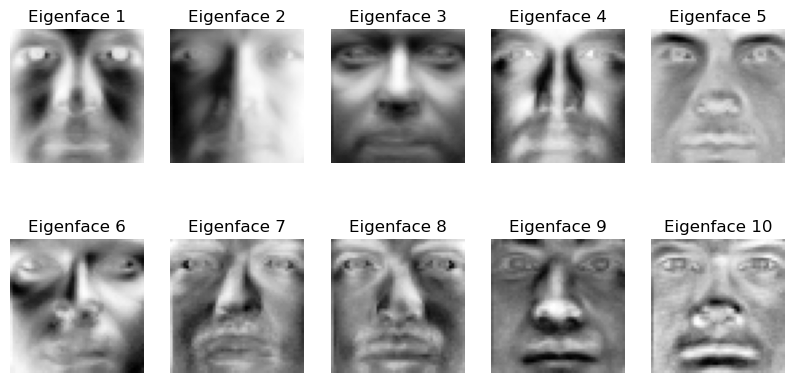

In [385]:
# Perform eigendecomposition
# compute covariance matrix X^T X
cov_matrix = np.dot(train_mean_sub.T, train_mean_sub)

# perform singular value decomposition on covariance matrix to obtain eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# in revserse order
idx = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, idx]

# select top 10 eigenfaces
top_10_eigenfaces = eigenvectors[:, :10]

# Display the first 10 eigenfaces as 10 images in grayscale
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenvectors[: ,i].reshape(50, 50), cmap=cm.Greys_r)
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')
plt.savefig("Q1_e_first_10_eigenfaces")
plt.show()

## (f) Eigenface Feature

In [387]:
def get_eigenface_feature(r):
    # get first r eigenvalues (2500, r)
    V_r = eigenvectors[:, :r]
    
    # generate r-dimensional feature matrix F (540, r) of training set
    F = np.dot(train_mean_sub, V_r)
    
    # generate r-dimensional feature matrix F (540, r) of test set
    F_test = np.dot(test_mean_sub, V_r)
    return (F, F_test)

## (g) Face Recognition

In [389]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# for r = 10. Train a Logistic Regression model using F and test on F test. Report test accuracy
LogReg_model = LogisticRegression(multi_class="ovr", max_iter = int(1e4))

F, F_test = get_eigenface_feature(10)
LogReg_model.fit(F, train_labels)

print ("Test Accuracy for r = 10 is: " + str(LogReg_model.score(F_test, test_labels)))

Test Accuracy for r = 10 is: 0.8


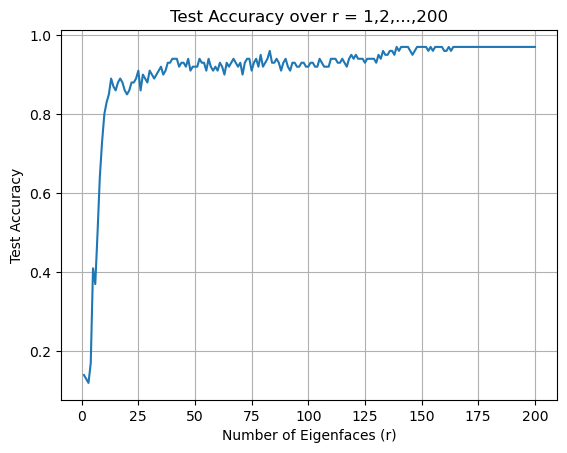

In [390]:
# Plot the classification accuracy on the test set as a function of r when r = 1,2,...,200.
acc = []
for r in range(1, 201):
    F, F_test = get_eigenface_feature(r)
    LogReg_model.fit(F, train_labels)
    acc.append(LogReg_model.score(F_test, test_labels))

plt.plot(range(1,201), acc)
plt.xlabel("Number of Eigenfaces (r)")
plt.ylabel("Test Accuracy")
plt.title('Test Accuracy over r = 1,2,...,200')
plt.savefig("Q1_g_all_accuracy")
plt.grid(True)
plt.show()

## (h) Low-Rank Data Loss

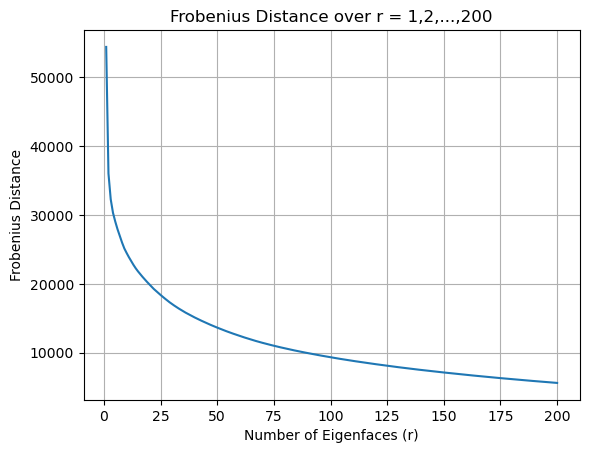

In [404]:
# Plot the average Frobenius distance between original data X and X_approx over r = 1,2,...,200
# define functions to calculate frobenius distance
def frobenius_distance(X, X_approx):
    diff = X - X_approx
    frob_dist = np.sqrt(np.trace(np.dot(diff.T, diff)))
    return frob_dist

frobenius_distances = []

# loop from r = 1 to 200
for r in range(1, 201):
    V_r = eigenvectors[:, :r]

    F, F_test = get_eigenface_feature(r)
    
    # reconstruct X_approx
    X_approx = np.dot(F[:, :r], V_r.T)
    
    distance = frobenius_distance(train_mean_sub, X_approx)
    frobenius_distances.append(distance)

# Plot Frobenius distance over r = 1,2,...,200
plt.plot(range(1, 201), frobenius_distances)
plt.xlabel("Number of Eigenfaces (r)")
plt.ylabel("Frobenius Distance")
plt.title("Frobenius Distance over r = 1,2,...,200")
plt.savefig("Q1_h")
plt.grid(True)
plt.show()